In [0]:
!git clone https://github.com/ai-techsystems/dnnCompiler
!sudo apt-get update
!sudo apt-get install build-essential python3.6-dev python3-pip swig doxygen 
#!clang-format clang clang-8 llvm-8 llvm-8-dev
!sudo pip3 install numpy onnx

In [0]:
import os
os.chdir('/content/dnnCompiler/')
!pwd
!make CC=g++ DEEPC

In [0]:
import os, sys
import deepC.dnnc as dc
import urllib.request
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## Download sample image

In [4]:
local_image    = '/content/local.jpg'
compressed_image = '/content/local_compressed.jpg'
if (False == os.path.exists(local_image)):
  internet_image = 'https://www.jpchacha.com/blog/content/00000002/lena_256.jpg'
  #internet_image = '/content/obama.jpg'
  urllib.request.urlretrieve(internet_image, local_image)
print("image size:", os.stat(local_image).st_size)

image size: 43438


## Load image into DNNC array

In [0]:
img = Image.open(local_image)
width, height = img.size; channels = 3

pixels = list(img.getdata())
pixels = [pixels[i * width:(i + 1) * width] for i in range(height)]

dc_pixels=dc.array(height, width, channels).asTypeInt()
for i,row in enumerate(pixels):
  for j, col in enumerate(row):
    for k, pix in enumerate(col):
      dc_pixels[i,j,k] = pix

## KMeans Clustering algorithm

In [0]:
class kMeans:
  def __init__(self, n_clusters=16, max_iter=300):
    self.n_clusters = n_clusters;
    self.max_iters  = max_iter;
    self.centroids  = None;
    self.labels     = None;

  def init_centroids(self, points):
    """initialize centroids as first n pixel points"""

    centroids = points[:self.n_clusters, 0, :channels].copy(); # n_clusters x channels
    for x in range(self.n_clusters):
      i = int(points.shape()[0]*np.random.sample())
      j = int(points.shape()[1]*np.random.sample())
      centroids[x, :channels]=points[i,j,:channels]
    return centroids;

  def closest_centroids(self, points, centroids):
    """returns the new centroids assigned from the points closest to them"""
    distances = dc.abs(points - centroids.reshape(self.n_clusters, 1,1,channels))
    return dc.argmin(distances, 0)

  def move_centroids(self, points, closest):
    """move centroids to the newly adjusted mean of the cluster"""
    # return dc.array([points[closest==k].mean(axis=0) for k in range(centroids.shape[0])])
    new_centroids_pt_sum = dc.zeros(self.n_clusters, channels)
    pts_in_new_centroids = dc.zeros(self.n_clusters, channels)
    for i in range(points.shape()[0]):
      for j in range(points.shape()[1]):
        for k in range(points.shape()[2]):
          cluster_index = closest[i,j,k]
          new_centroids_pt_sum[cluster_index,k] = new_centroids_pt_sum[cluster_index,k] + points[i,j,k]
          pts_in_new_centroids[cluster_index,k] = pts_in_new_centroids[cluster_index,k] + 1.0
    return new_centroids_pt_sum / pts_in_new_centroids

  def fit(self, points):
    self.centroids = self.init_centroids(points);
    for n in range(self.max_iters):
      self.labels = self.closest_centroids(points, self.centroids)
      self.centroids = self.move_centroids(points, self.labels)

## Run KMeans

In [0]:
#%%timeit
N=8
model=kMeans(n_clusters=N, max_iter=2)
model.fit(dc_pixels)

## Cluster Assignment

In [0]:
new_image = dc_pixels.copy()
for i in range(dc_pixels.shape()[0]):
  for j in range(dc_pixels.shape()[1]):
    for k in range(dc_pixels.shape()[2]):
      cluster_index = model.labels[i,j,k]
      new_image[i,j,k] = int(model.centroids[cluster_index,k])

## Save Image

In [0]:
comp_image=Image.fromarray(np.uint8(new_image.numpy()))
comp_image.save(compressed_image)
img_1 = mpimg.imread(local_image)
img_2 = mpimg.imread(compressed_image)

In [10]:
print("original  image size:", os.stat(local_image).st_size, dc_pixels.shape())
print("compressed image size:", os.stat(compressed_image).st_size, new_image.shape())

original  image size: 43438 (256, 256, 3)
compressed image size: 12612 (256, 256, 3)


## Display Image

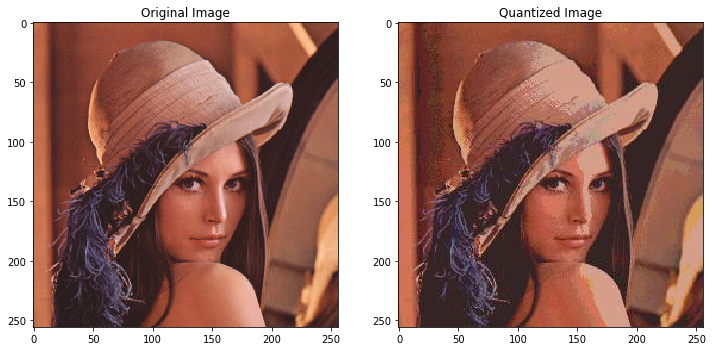

In [11]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(12,12))
ax1.imshow(img_1)
ax1.set_title('Original Image')
ax2.imshow(img_2)
ax2.set_title('Quantized Image')
plt.show()